In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, sys
import glob
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
from sklearn.utils import check_X_y, safe_mask, as_float_array

# proj_path = '/content/drive/MyDrive/STAT685/project'
proj_path = 'G:\My Drive\STAT685\project'

control_path = os.path.join(proj_path, 'DATA/Control/')
control_files = glob.glob(os.path.join(control_path, "Control*.csv"))
control_files.sort()
print(control_files[0:5])

case_path = os.path.join(proj_path, 'DATA/Ovarian_Cancer/')
case_files = glob.glob(os.path.join(case_path, "Ovarian Cancer*.csv"))
case_files.sort()
print(case_files[0:5])

this_file = case_files[0]
prot_spec = pd.read_csv(this_file)
print(prot_spec.head())

prot_spec_ar = np.array(prot_spec['Intensity'])
print(prot_spec_ar[0:5])

# calculate the maximum measurements you could use
# i.e. some power of 2, or related to the size of wavelet filter you want to use

np.log2(len(prot_spec_ar))
pywt.Wavelet('db3')

# what about for a window of length 512?
pywt.dwt_max_level(len(prot_spec_ar), 'db3')
pywt.dwt_max_level(512, 'db4')
pywt.dwt_coeff_len(512, pywt.Wavelet('db4'), mode = 'periodization')

wave_coefs = pywt.wavedec(prot_spec_ar, 'db3', mode = 'periodization', level=5)
len(wave_coefs[1])
[len(i) for i in wave_coefs]

['/content/drive/MyDrive/STAT685/project/DATA/Control/Control daf-0181.csv', '/content/drive/MyDrive/STAT685/project/DATA/Control/Control daf-0182.csv', '/content/drive/MyDrive/STAT685/project/DATA/Control/Control daf-0183.csv', '/content/drive/MyDrive/STAT685/project/DATA/Control/Control daf-0184.csv', '/content/drive/MyDrive/STAT685/project/DATA/Control/Control daf-0185.csv']
['/content/drive/MyDrive/STAT685/project/DATA/Ovarian_Cancer/Ovarian Cancer daf-0601.csv', '/content/drive/MyDrive/STAT685/project/DATA/Ovarian_Cancer/Ovarian Cancer daf-0602.csv', '/content/drive/MyDrive/STAT685/project/DATA/Ovarian_Cancer/Ovarian Cancer daf-0604.csv', '/content/drive/MyDrive/STAT685/project/DATA/Ovarian_Cancer/Ovarian Cancer daf-0605.csv', '/content/drive/MyDrive/STAT685/project/DATA/Ovarian_Cancer/Ovarian Cancer daf-0606.csv']
            M/Z  Intensity
0 -7.860261e-05   4.100553
1  2.177358e-07   4.120664
2  9.602147e-05   4.036199
3  3.660138e-04   4.124686
4  8.101948e-04   4.026144
[4.100

[474, 474, 948, 1895, 3789, 7577]

In [3]:
[len(np.unique(coefs)) for coefs in wave_coefs]

# np.sort(wave_coefs[-1])

[474, 474, 948, 1895, 3789, 7567]

In [3]:
# wavelet packet?
# https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/Wavelet_packet_entropy_features_python.ipynb

# could add maxlevel after mode
wavelet = 'db3'
# maxlevel = pywt.dwt_max_level(len(prot_spec_ar), wavelet)
maxlevel = 3
wave_pack = pywt.WaveletPacket(prot_spec_ar, wavelet, mode = 'periodization', maxlevel = maxlevel)

packet_names = [node.path for node in wave_pack.get_level(maxlevel, "natural")]

# length of the subbands at maxlevel decomposition
[wave_pack[node.path].data.shape for node in wave_pack.get_level(maxlevel, "natural")]

sub_coeffs = [wave_pack[node.path].data for node in wave_pack.get_level(maxlevel, "natural")]

[len(np.unique(coeffs)) for coeffs in sub_coeffs]

[1895, 1895, 1895, 1895, 1895, 1895, 1895, 1895]

In [18]:
# but maybe this is entropy for just a simple, non-packet decomposition?

# https://github.com/ArunAniyan/Wavelet-Entropy/blob/master/wventrpy.m

x = prot_spec_ar

n = len(x)
a = x
l = 5

window_size = 1024
window_step = 500
maxstart = len(x) - window_size
len(x)
starts = np.arange(0, maxstart, window_step)

def wventropy(x, l, wav, mode):
  n = len(x)
  a = x
  coefs = pywt.wavedec(x, wav, mode = mode, level = l)
  coefs = coefs[1:]
  # TODO why is this divided by n?
  # E = [(np.sum(vals ** 2)) / n for vals in coefs]
  # TODO trying it without dividing by
  E = [(np.sum(vals ** 2)) for vals in coefs]
  # Total energy
  Etot = np.sum(E)
  # Relative total energy
  P = [Ej / Etot for Ej in E]
  # TODO should this be natural log or log2?? or something else?
  WTE = -(np.sum(P * np.log(P)))

  return (WTE, P)

WTE, P = wventropy(prot_spec_ar, l, wavelet, 'periodization')
print(WTE, P)

# TODO try calculating the entropy for the Wavelet packet decomposition
# probably requires rewritng the script
# consider that for MATLAB wentropy, it handles X being data or a wavelet packet decomposition

1.0697456498562241 [0.49326361035148836, 0.37623229667869673, 0.09793212737888682, 0.02738174466421058, 0.005190220926717579]


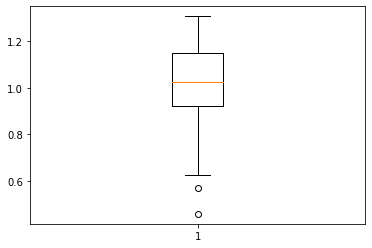

In [5]:
xx = np.arange(20)

xx[15:20]

entropies = [wventropy(x[start:(start+window_size)], l, wavelet, 'periodization')[0] for start in starts]

plt.boxplot(entropies)
plt.show()

In [9]:
# read in the raw intensity values

# X_dir_sample = np.genfromtxt(case_files[0], delimiter = ',', skip_header = 1, usecols = (1))

# X_dir_case = np.zeros((len(case_files), X_dir_sample.shape[0]))

# for i in range(len(case_files)):
#   X_i = np.genfromtxt(case_files[i], delimiter = ',', skip_header = 1, usecols = (1))
#   X_dir_case[i, :] = X_i

# X_dir_case.shape

# X_dir_control = np.zeros((len(control_files), X_dir_sample.shape[0]))

# for i in range(len(control_files)):
#   X_i = np.genfromtxt(control_files[i], delimiter = ',', skip_header = 1, usecols = (1))
#   X_dir_control[i, :] = X_i

# X_dir_control.shape

# X_dir = np.concatenate((X_dir_case, X_dir_control), axis = 0)

# y = np.concatenate((np.ones((len(X_dir_case), )),
#                     np.zeros((len(X_dir_control), ))),
#                    axis = 0)
# y = y.astype(np.int8)

# dir_colnames = [f'int_{i}' for i in range(X_dir_sample.shape[0])]

# X_dir_df = pd.DataFrame(X_dir, columns = dir_colnames)
# X_dir_df['y'] = y

# X_dir_df.to_csv(os.path.join(proj_path, 'DATA/all_intensities_8-7-02.csv'), index = False)

In [32]:
int_8702 = pd.read_csv(os.path.join(proj_path, 'DATA/all_intensities_8-7-02.csv'))

int_8702.head()

int_colnames = int_8702.columns

X_int = int_8702.iloc[:, :-1].to_numpy()
y = int_8702.iloc[:, -1].ravel()
print(X_int.shape)
print(y.shape)

(253, 15154)
(253,)


In [17]:
def fisher_table(*args):
  args = [as_float_array(a) for a in args]
  fisher_score = ((np.mean(args[0], axis = 0) - np.mean(args[1], axis = 0))**2 /
    (np.var(args[0], axis = 0) + np.var(args[1], axis = 0)))
  return fisher_score

def fisher_crit(X, y):
  # TODO somehow check that y only has 2 unique values?
  # TODO check that X has at least K features? or maybe SelectKBest already does that
  X, y = check_X_y(X, y)
  args = [X[safe_mask(X, y == k)] for k in np.unique(y)]
  return fisher_table(*args)

# TODO also try this with Power Transforming and scaling the features

# X_new = SelectKBest(fisher_crit, k=5).fit_transform(X_dir, y)

# X_dir_pf = power_transform(X_new)
# skb = SelectKBest(fisher_crit, k=10).fit(power_transform(X_dir), y)
# skb.get_feature_names_out(dir_colnames)

# X_dir_pf = PowerTransformer().fit_transform(X_dir)

# np.max(X_dir)

In [44]:
# make X matrix with entropy values

X_ent = np.zeros((X_int.shape[0], len(starts)))

for i in range(X_ent.shape[0]):
  entropies = [wventropy(X_int[i, start:(start+window_size)], l, wavelet, 'periodization')[0] for start in starts]
  X_ent[i, :] = entropies

# dir_colnames = [f'int_{i}' for i in range(X_dir_sample.shape[0])]

ent_colnames = [f'ent_{i}' for i in range(X_ent.shape[1])]

X = np.concatenate((X_ent, X_int), axis = 1)

In [45]:
print(X_ent.shape, y.shape)
print(X.shape)

(253, 15183)


In [40]:
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     RepeatedStratifiedKFold, GridSearchCV)
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, power_transform, PowerTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 123)

cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 456)
rng = np.random.RandomState(0)
scoring = ['roc_auc', 'accuracy']

plt.boxplot(X_train)
plt.show()

plt.boxplot(StandardScaler().fit_transform(X_train))
plt.show()

plt.boxplot(power_transform(X_train))
plt.show()

# a function to return a dataframe with useful columns from CV results
def cv_summary(cv_obj, score_names = ['score']):
  cv_res = pd.DataFrame(cv_obj.cv_results_)
  cols = [col for col in cv_res.columns if 'param_' in col]
  stats = ['mean', 'std', 'rank']
  test_score_names = [stat+'_test_'+score for score in score_names for stat in stats]
  test_scores = [col for col in cv_res.columns if col in test_score_names]
  cols.extend(test_scores)
  return(cv_res[cols].sort_values(test_score_names[0], ascending = False))

In [ ]:
# making the feature transforming pipeline

# would it be simpler if I was feeding these in as a dataframe?

# need column selectors

# basically, what do I want to do?

# on the intensity columns: 
#  - select 10 using Fisher crit
#  - PowerTransformer
# on the entropy columns: 
#  - PowerTransformer
#  - select 5 using RFE with logistic regression

# then, put all of them into LogisticRegression

int_pipe = Pipeline([
    ('skb_fish', SelectKBest(fisher_crit, k = 10)),
    ('power_trans', PowerTransformer())
])

ent_pipe = Pipeline([
    ('power_trans'. PowerTransformer()),
    ('rfe': RFE(LogisticRegression(), n_features_to_select = 5))
])

int_select = make_column_selector(pattern = 'int_')
ent_select = make_column_selector(pattern = 'ent_')
col_trans = ColumnTransformer([
    ('int', int_pipe, int_select),
    ('ent', ent_pipe, ent_select)
])

logreg = LogisticRegression(penalty = 'elasticnet', solver = 'saga', 
                            max_iter = 200, random_state = rng)
lr_params = {'logreg__C': [0.01, 0.1, 1, 5, 10, 25],
             'logreg__class_weight': ['balanced', None],
             'logreg__l1_ratio': [0, 0.25, 0.5, 0.75, 1]}

comb_pipe = Pipeline([
    ('col_trans', col_trans),
    ('logreg', logreg)
])

<AxesSubplot:xlabel='window', ylabel='x'>

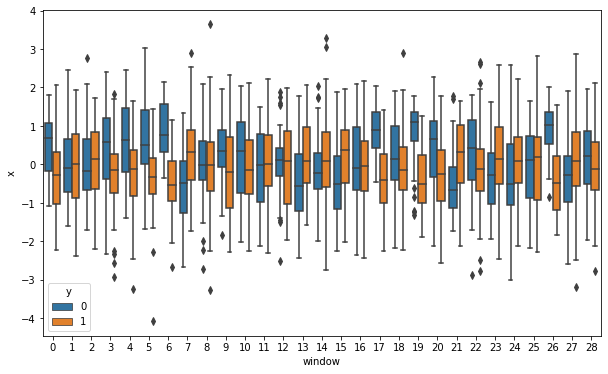

In [93]:
# trying to do boxplots for each variable, with a separate one for each outcome class

colnames = [f'x{i}' for i in range(29)]
df_train = pd.DataFrame(power_transform(X_train), columns = colnames)
df_train['y'] = y_train
df_train['id'] = df_train.index

df_train_wide = pd.wide_to_long(df = df_train, stubnames=['x'], i = 'id', j = 'window')

df_train_wide['window'] = df_train_wide.index.get_level_values('window')
df_train_wide = df_train_wide.set_index(df_train_wide.index.get_level_values('id'))

df_train_wide.head()

# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data = df_train_wide, x = 'window', y = 'x', hue = 'y', ax=ax)

In [18]:
lr_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LogisticRegressionCV(random_state=123))
])

lr_pipe.fit(X_train, y_train)

y_pred = lr_pipe.predict(X_test)

print(confusion_matrix(y_test, y_pred))

[[34  1]
 [ 1 48]]


In [30]:
from sklearn.feature_selection import RFE

rfe_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('rfe', RFE(LogisticRegression(), n_features_to_select = 5)),
    ('lr', LogisticRegressionCV(random_state=123))
])

rfe_pipe.fit(X_train, y_train)

y_pred = rfe_pipe.predict(X_train)

print(confusion_matrix(y_train, y_pred))

rfe_pipe

# print(rfe_cv.best_estimator_.named_steps.rfe.get_feature_names_out())

print(rfe_pipe.named_steps.rfe.get_feature_names_out())

rfe_lr_scores = cross_val_score(rfe_pipe, X_train, y_train, scoring = 'accuracy', cv = cv, n_jobs = -1)

[[ 53   3]
 [  1 112]]
['x0' 'x6' 'x7' 'x17' 'x26']


In [31]:
print(np.mean(rfe_lr_scores), np.std(rfe_lr_scores)/(len(rfe_lr_scores)**0.5))

0.9547831253713607 0.007792317516009945


In [24]:
logreg = LogisticRegression(penalty = 'elasticnet', solver = 'saga', 
                            max_iter = 200, random_state = rng)
lr_params = {'logreg__C': [0.01, 0.1, 1, 5, 10, 25],
             'logreg__class_weight': ['balanced', None],
             'logreg__l1_ratio': [0, 0.25, 0.5, 0.75, 1]}

rfe_lr_pipe = Pipeline([('power', PowerTransformer()),
                        ('rfe', RFE(LogisticRegression(), n_features_to_select = 5)),
                        ('logreg', logreg)])

lr_cv = GridSearchCV(rfe_lr_pipe, param_grid=lr_params, scoring = scoring, 
                     n_jobs=-1, refit='roc_auc', cv=cv, verbose = 4)

lr_cv.fit(X_train, y_train)

Fitting 15 folds for each of 60 candidates, totalling 900 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=456),
             estimator=Pipeline(steps=[('power', PowerTransformer()),
                                       ('rfe',
                                        RFE(estimator=LogisticRegression(),
                                            n_features_to_select=5)),
                                       ('logreg',
                                        LogisticRegression(max_iter=200,
                                                           penalty='elasticnet',
                                                           random_state=RandomState(MT19937) at 0x7F60613DE840,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.01, 0.1, 1, 5, 10, 25],
                         'logreg__class_weight': ['balanced', None],
                         'logreg__l1_ratio': [0, 0.25, 0.5, 0.75, 1]},
             refit='roc_auc', scoring=['roc_auc', 'accuracy'], verbose=4)

In [34]:
print(lr_cv.best_score_)
print(lr_cv.best_estimator_.named_steps.rfe.get_feature_names_out())
print(lr_cv.best_estimator_)

lr_cv_summ = cv_summary(lr_cv, scoring)
print(np.max(lr_cv_summ['mean_test_accuracy'])) 

y_pred = lr_cv.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, y_pred))

print(lr_cv_summ.head())

0.9349112426035503

In [27]:
# my conclusion is that the SelectKBest still takes a while, but the PowerTransformer features definitely look better

# seems worth it to do RFE

fclassif_lr_pipe = Pipeline([('power', PowerTransformer()),
                            ('skb', SelectKBest(f_classif, k = 5)),
                            ('logreg', logreg)])

fclassif_cv = GridSearchCV(fclassif_lr_pipe, param_grid=lr_params, 
                           scoring = scoring, n_jobs=-1, refit='roc_auc', cv=cv,
                           verbose = 4)
fclassif_cv.fit(X_train, y_train)

Fitting 15 folds for each of 60 candidates, totalling 900 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=456),
             estimator=Pipeline(steps=[('power', PowerTransformer()),
                                       ('skb', SelectKBest(k=5)),
                                       ('logreg',
                                        LogisticRegression(max_iter=200,
                                                           penalty='elasticnet',
                                                           random_state=RandomState(MT19937) at 0x7F60613DE840,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.01, 0.1, 1, 5, 10, 25],
                         'logreg__class_weight': ['balanced', None],
                         'logreg__l1_ratio': [0, 0.25, 0.5, 0.75, 1]},
             refit='roc_auc', scoring=['roc_auc', 'accuracy'], verbose=4)

In [28]:
print(fclassif_cv.best_score_)
print(fclassif_cv.best_estimator_)

fclassif_cv_summ = cv_summary(fclassif_cv, scoring)
print(np.max(fclassif_cv_summ['mean_test_accuracy']))
print(fclassif_cv_summ.head())

y_pred = fclassif_cv.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, y_pred))

0.9791382201461253
Pipeline(steps=[('power', PowerTransformer()), ('skb', SelectKBest(k=5)),
                ('logreg',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    l1_ratio=0.25, max_iter=200,
                                    penalty='elasticnet',
                                    random_state=RandomState(MT19937) at 0x7F6060567040,
                                    solver='saga'))])
0.9288175876411171
   param_logreg__C param_logreg__class_weight param_logreg__l1_ratio  \
11             0.1                   balanced                   0.25   
10             0.1                   balanced                      0   
12             0.1                   balanced                    0.5   
25               1                       None                      0   
16             0.1                       None                   0.25   

    mean_test_roc_auc  std_test_roc_auc  rank_test_roc_auc  \
11           0.979138          0